In [11]:
import pandas as pd

t_file_path = r"J:\downloads\vidrio T.Sample.ASC"
r_file_path = r"J:\downloads\vidrio R 2.ASC"

t_df = pd.read_csv(
    t_file_path,
    header=90,
    names=["wavelength", "T_meas"],
    decimal=",",
    sep = "\t",
    dtype=float
)

r_df = pd.read_csv(
    r_file_path,
    header=90,
    names=["wavelength", "R_meas"],
    decimal=",",
    sep = "\t",
    dtype=float
)


In [12]:
r_df["R_meas"] = r_df["R_meas"] /100
t_df["T_meas"] = t_df["T_meas"] /100

In [13]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def savitzky_golay_filtering(
    t_df: pd.DataFrame,
    r_df: pd.DataFrame,
    window_length: int = 11,
    polyorder: int = 3,
    clip_01: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Apply Savitzky–Golay smoothing to T_meas and R_meas, respectively.
    - Sorts by wavelength
    - Adjusts window_length to be odd and <= len(df)
    - Optionally clips results to [0,1]
    Returns new dataframes (does not mutate inputs).
    """
    def _prep_window(n, w, p):
        w = int(w)
        if w % 2 == 0:
            w += 1
        w = min(w, n if n % 2 == 1 else n-1)
        if w < p+2:   # need enough points for the polynomial fit
            w = p + 2 if (p + 2) % 2 == 1 else p + 3
        w = max(3, w)
        w = min(w, n if n % 2 == 1 else n-1)
        return max(3, w)

    def _smooth(df, val_col):
        df2 = df.copy()
        df2 = df2.dropna(subset=["wavelength", val_col])
        df2 = df2.sort_values("wavelength").reset_index(drop=True)
        n = len(df2)
        if n < 3:
            # too short to smooth; return as-is
            return df2
        w = _prep_window(n, window_length, polyorder)
        try:
            smoothed = savgol_filter(df2[val_col].to_numpy(dtype=float),
                                     window_length=w, polyorder=polyorder, mode="interp")
        except ValueError:
            # fallback if something odd happens
            smoothed = df2[val_col].to_numpy(dtype=float)
        if clip_01:
            smoothed = np.clip(smoothed, 0.0, 1.0)
        df2[val_col] = smoothed
        return df2

    t_out = _smooth(t_df, "T_meas")
    r_out = _smooth(r_df, "R_meas")
    return t_out, r_out


In [14]:
# Preprocess
t_smooth, r_smooth = savitzky_golay_filtering(t_df, r_df, window_length=11, polyorder=3)

In [15]:
import numpy as np
import pandas as pd
import torch
from tmm_fast import coh_tmm
import matplotlib.pyplot as plt

def fit_nk_from_TR_gpu(
    t_df: pd.DataFrame,
    r_df: pd.DataFrame,
    d_glass: float = 1000.0,
    n_min: float = 1.3,
    n_max: float = 2.5,
    n_steps: int = 50,
    k_min: float = 0.0,
    k_max: float = 0.5,
    k_steps: int = 50,
    pol: str = 's',
    plot: bool = True,
    device: str | None = None,
) -> pd.DataFrame:
    """
    GPU/CPU vectorized fitter for n,k from measured T and R using tmm_fast.coh_tmm.
    Batches over the (n,k) grid for each wavelength. Uses W=1 per call (per-wavelength),
    and batches along the 'stack' dimension (NK).
    """
    # --- Merge & sanity
    df = pd.merge(t_df, r_df, on="wavelength", how="inner").copy()
    df["A_meas"] = 1.0 - df["T_meas"] - df["R_meas"]

    # Select device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Build search grid on device
    n_range = torch.linspace(n_min, n_max, steps=n_steps, dtype=torch.float32, device=device)
    k_range = torch.linspace(k_min, k_max, steps=k_steps, dtype=torch.float32, device=device)
    N, K = torch.meshgrid(n_range, k_range, indexing="ij")  # [n_steps, k_steps]
    n_vec = N.reshape(-1)  # [NK]
    k_vec = K.reshape(-1)  # [NK]
    NK = n_vec.numel()

    # Pre-build constant stacks on device: air | material | air
    n_air = torch.ones((NK, 1, 1), dtype=torch.complex64, device=device)
    n_mat = (n_vec - 1j * k_vec).reshape(NK, 1, 1).to(torch.complex64)
    n_complex = torch.cat([n_air, n_mat, n_air], dim=1)  # [NK, 3, 1]

    d_list = torch.tensor([torch.inf, d_glass, torch.inf],
                          dtype=torch.float32, device=device).repeat(NK, 1)  # [NK, 3]

    best_ns, best_ks = [], []

    # Loop over wavelengths only (grid is batched across NK stacks)
    for _, row in df.iterrows():
        lam = float(row["wavelength"])
        R_meas = float(row["R_meas"])
        T_meas = float(row["T_meas"])
        A_meas = float(row["A_meas"])

        # IMPORTANT: W=1 here; batch is along stacks (NK)
        lam_vac = torch.tensor([lam], dtype=torch.float32, device=device)  # [1]
        theta   = torch.zeros((1,), dtype=torch.float32, device=device)    # [1]

        # Run TMM for all (n,k) at this wavelength
        res = coh_tmm(pol, n_complex, d_list, theta, lam_vac)

        # Flatten to [NK]
        R = res['R'].real.reshape(-1)
        T = res['T'].real.reshape(-1)
        A = 1.0 - R - T

        # Error vs measurements
        err = (R - R_meas)**2 + (T - T_meas)**2 + (A - A_meas)**2

        # Best index
        idx = torch.argmin(err)
        best_ns.append(n_vec[idx].item())
        best_ks.append(k_vec[idx].item())

    df["best_n"] = best_ns
    df["best_k"] = best_ks

    if plot:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(df["wavelength"], df["best_n"], "-o")
        plt.xlabel("Longitud de onda (nm)")
        plt.ylabel("Índice de refracción real (n)")
        plt.title("n vs Longitud de onda")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(df["wavelength"], df["best_k"], "-o", color="r")
        plt.xlabel("Longitud de onda (nm)")
        plt.ylabel("Índice de refracción imaginario (k)")
        plt.title("k vs Longitud de onda")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return df


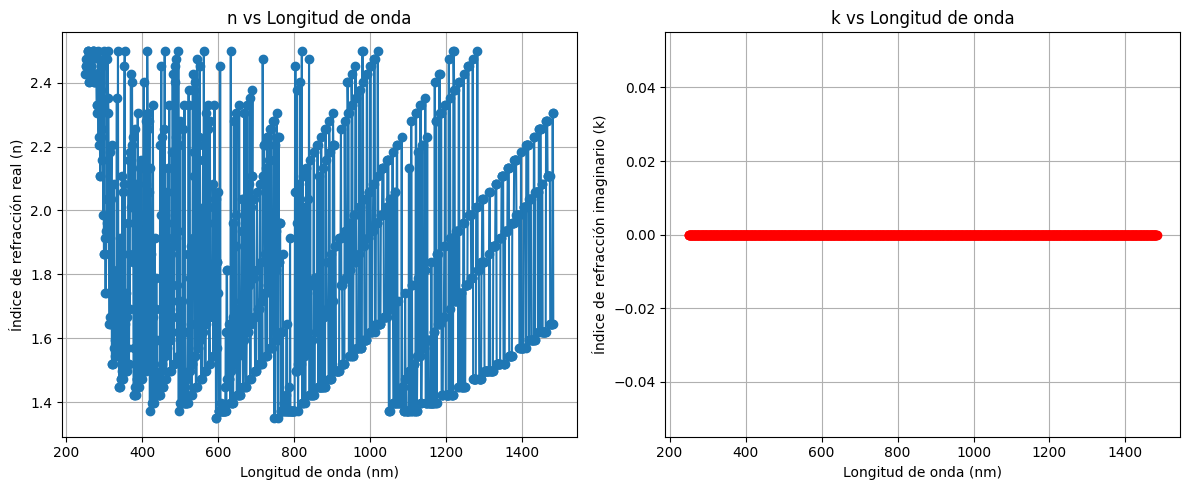

fit_nk_from_TR_gpu took 12.051 s


In [16]:
from time import perf_counter

start = perf_counter()
result_df = fit_nk_from_TR_gpu(t_smooth, r_smooth, d_glass=1000.0, plot=True)
elapsed = perf_counter() - start
print(f"fit_nk_from_TR_gpu took {elapsed:.3f} s")


In [17]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tmm_fast import coh_tmm

def plot_TR_diagnostics(
    result_df: pd.DataFrame,
    d_glass: float = 1000.0,
    pol: str = "s",
    device: str | None = None,
    show_residuals: bool = False,
    save_path: str | None = None,
    show: bool = True,
) -> pd.DataFrame:
    """
    Overlay measured T, R, A with model-fitted values using best_n/best_k per wavelength.
    Shapes follow tmm_fast: N shape [S, L, W] with S=1, L=3 layers, W=#wavelengths.
    """
    required = {"wavelength","T_meas","R_meas","A_meas","best_n","best_k"}
    if not required.issubset(result_df.columns):
        missing = required - set(result_df.columns)
        raise ValueError(f"result_df missing columns: {missing}")

    df = result_df.dropna(subset=list(required)).copy()
    df = df.sort_values("wavelength").reset_index(drop=True)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Wavelength axis (W)
    wl = df["wavelength"].to_numpy()
    W = len(wl)
    lam_vac = torch.tensor(wl, dtype=torch.float32, device=device)  # [W]

    # Build N with S=1 stack, L=3 layers, W wavelengths
    # air | material(best_n,k per wavelength) | air
    n_air = torch.ones((1, 1, W), dtype=torch.complex64, device=device)     # [1,1,W]
    n_mat = torch.tensor(
        (df["best_n"].to_numpy() - 1j*df["best_k"].to_numpy()).reshape(1,1,W),
        dtype=torch.complex64, device=device
    )  # [1,1,W]
    N = torch.cat([n_air, n_mat, n_air], dim=1)  # [1,3,W]

    # Thickness T must be [S, L] = [1,3]
    T = torch.tensor([[float('inf'), d_glass, float('inf')]],
                     dtype=torch.float32, device=device)  # [1,3]

    # Theta is [A]; use A=1 (normal incidence)
    Theta = torch.zeros((1,), dtype=torch.float32, device=device)  # [1]

    with torch.no_grad():
        res = coh_tmm(pol, N, T, Theta, lam_vac)
        R_fit = res["R"].real.reshape(-1).detach().cpu().numpy()  # [W]
        T_fit = res["T"].real.reshape(-1).detach().cpu().numpy()  # [W]
        A_fit = 1.0 - R_fit - T_fit

    # Measured
    R_meas = df["R_meas"].to_numpy()
    T_meas = df["T_meas"].to_numpy()
    A_meas = df["A_meas"].to_numpy()

    # Residuals
    R_res = R_meas - R_fit
    T_res = T_meas - T_fit
    A_res = A_meas - A_fit

    # Store
    df["R_fit"] = R_fit
    df["T_fit"] = T_fit
    df["A_fit"] = A_fit
    df["R_resid"] = R_res
    df["T_resid"] = T_res
    df["A_resid"] = A_res

    # --- Plots ---
    # Main overlay
    plt.figure(figsize=(12, 9))
    plt.subplot(3,1,1)
    plt.plot(wl, R_meas, "o", label="R_meas")
    plt.plot(wl, R_fit,  "-", label="R_fit")
    plt.ylabel("Reflectancia (R)")
    plt.title("Mediciones vs Ajuste (TMM)")
    plt.grid(True); plt.legend()

    plt.subplot(3,1,2)
    plt.plot(wl, T_meas, "o", label="T_meas")
    plt.plot(wl, T_fit,  "-", label="T_fit")
    plt.ylabel("Transmitancia (T)")
    plt.grid(True); plt.legend()

    plt.subplot(3,1,3)
    plt.plot(wl, A_meas, "o", label="A_meas")
    plt.plot(wl, A_fit,  "-", label="A_fit")
    plt.xlabel("Longitud de onda (nm)")
    plt.ylabel("Absorbancia (A)")
    plt.grid(True); plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    # Residuals (optional)
    if show_residuals:
        plt.figure(figsize=(12, 7))
        plt.subplot(3,1,1); plt.plot(wl, R_res, "o-"); plt.ylabel("R resid"); plt.grid(True)
        plt.subplot(3,1,2); plt.plot(wl, T_res, "o-"); plt.ylabel("T resid"); plt.grid(True)
        plt.subplot(3,1,3); plt.plot(wl, A_res, "o-"); plt.xlabel("λ (nm)"); plt.ylabel("A resid"); plt.grid(True)
        plt.tight_layout()
        if save_path:
            base = save_path.rsplit(".", 1)[0]
            plt.savefig(f"{base}_residuals.png", dpi=150, bbox_inches="tight")
        if show:
            plt.show()
        else:
            plt.close()

    return df


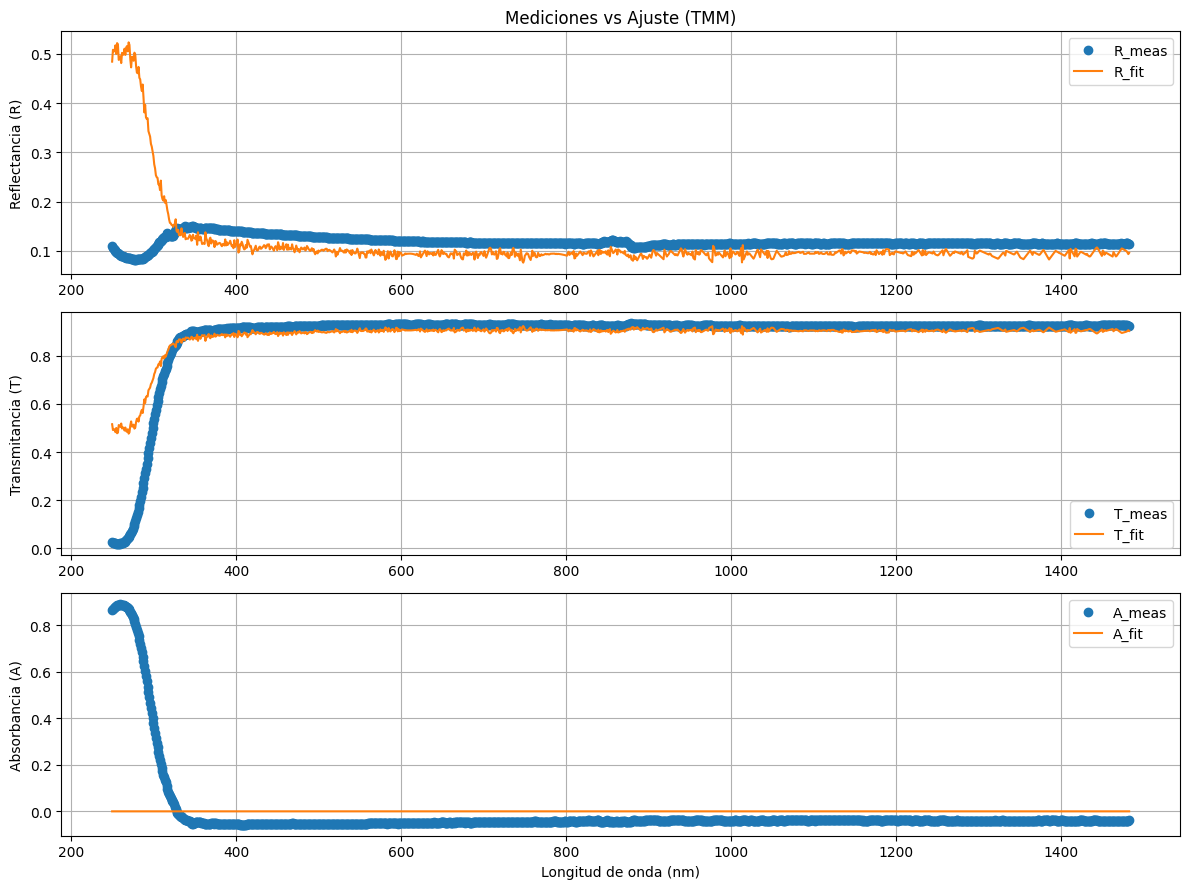

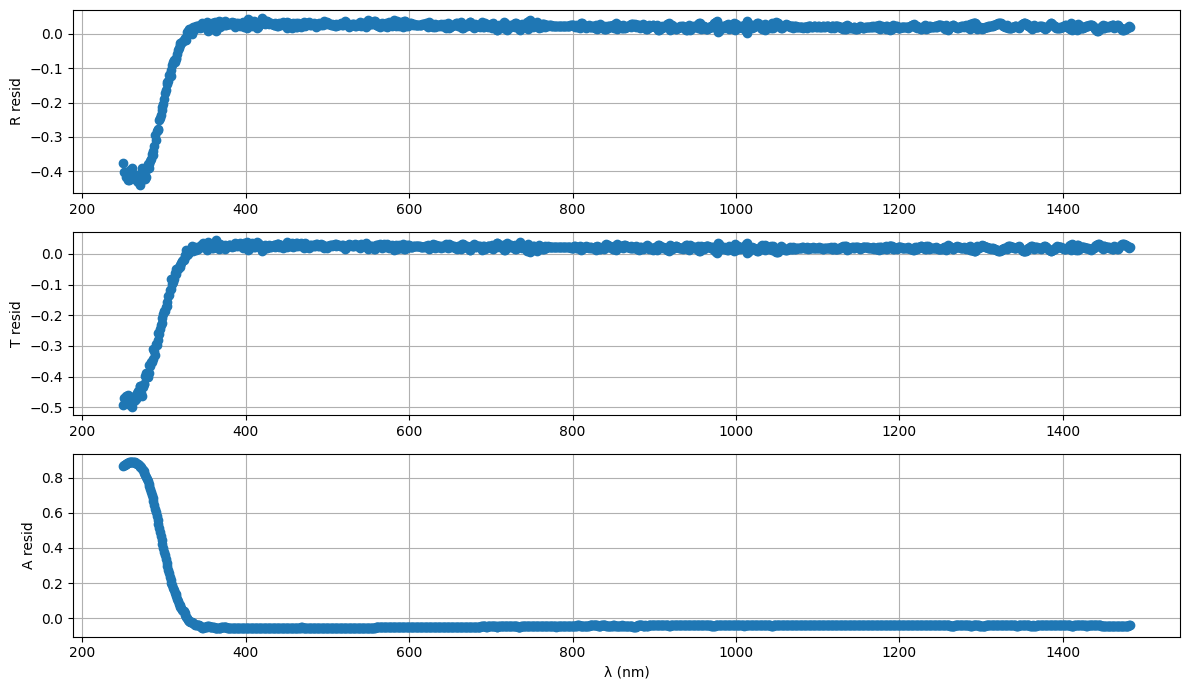

In [18]:
# result_df is what you got from fit_nk_from_TR or fit_nk_from_TR_gpu
diag_df = plot_TR_diagnostics(
    result_df,
    d_glass=1000.0,
    pol="s",
    show_residuals=True,
    save_path="diagnostic_TR.png"
)
# diag_df now also contains R_fit, T_fit, A_fit and residuals.
